# Imports

In [12]:
import os
import json
import matplotlib.pyplot as plt

In [13]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [14]:
import pandas as pd
pd.options.display.max_columns = None

In [6]:
%run ../utils/__init__.py
%run ../metrics/__init__.py

# Functions

In [7]:
%run ../utils/files.py

In [8]:
TASK = 'cls'

In [9]:
TASK_FOLDER = _get_task_folder(TASK)
BASE_FOLDER = os.path.join(WORKSPACE_DIR, TASK_FOLDER)
RESULTS_FOLDER = os.path.join(BASE_FOLDER, 'results')

In [99]:
def load_results_deprecated(run_name, additional=None):
    all_results = []

    folder = os.path.join(RESULTS_FOLDER, run_name)

    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)

        if not os.path.isfile(filepath):
            continue
            
        if additional and additional not in filename:
            continue

        with open(filepath, 'r') as f:
            results = json.load(f)

        additional_name = filename.replace('metrics', '').replace('.json', '')
        all_results.append((additional_name, results))

    return all_results

In [100]:
def load_metrics(run_name):
    filepath = os.path.join(RESULTS_FOLDER, run_name, 'metrics.json')
    
    if not os.path.isfile(filepath):
        raise FileNotFoundError(filepath)

    with open(filepath, 'r') as f:
        return json.load(f)

In [10]:
def load_outputs_csv(run_name):
    filepath = os.path.join(RESULTS_FOLDER, run_name, 'outputs.csv')
    
    if not os.path.isfile(filepath):
        raise FileNotFoundError(filepath)
    
    return pd.read_csv(filepath)

# Compare multiple models

In [21]:
from collections import defaultdict
import re

In [22]:
%run ../datasets/common/__init__.py
%run ../utils/plots.py

In [23]:
DISEASES = CXR14_DISEASES
len(DISEASES)

14

In [24]:
def shorten_run_name(run_name):
    group = re.search(r'\d{4}_\d{6}', run_name)
    return group[0]

## CMs

In [97]:
# TODO: implement for multiple dataset_types at the same time (see function below)

def plot_cms_multiple_runs(run_names, dataset_type='train', percentage=False):
    errors = defaultdict(list)

    n_runs = len(run_names)
    n_diseases = len(diseases)

    plt.figure(figsize=(n_runs*5, n_diseases * 3))

    for i_run, run_name in enumerate(run_names):
        results = load_metrics(run_name)      

        # for dataset_type in dataset_types:
        if dataset_type not in results:
            errors['dataset-type-not-found'].append(run_name)
            continue

        metrics = results[dataset_type]

        for i_disease, disease in enumerate(diseases):
            key = f'cm_{disease}'
            if key not in metrics:
                errors[f'{key}-not-in-metrics'].append(run_name)
                continue

            cm = metrics[key]

            subplt_index = n_runs * i_disease + i_run + 1
            plt.subplot(n_diseases, n_runs, subplt_index)

            title = shorten_run_name(run_name) if i_disease == 0 else None
            plot_cm(cm, title=title, percentage=percentage,
                    xlabel=(i_disease == n_diseases-1),
                    ylabel=False,
                   )
            plt.ylabel(disease)


        print(run_name)
    print(f'Dataset type: {dataset_type}')
    
    n_errors = sum(v for v in errors.values())
    if n_errors > 0:
        print('Errors: ', {k: len(v) for k, v in errors.items()})

In [73]:
run_names = [
#     '0123_174651_cxr14_mobilenet-v2_lr0.0001_hint_normS_size256_sch-roc_auc-p5-f0.1_noes',
    '0125_211742_cxr14_densenet-121-v2_lr0.0001_hint_normS_size200_sch-roc_auc-p5-f0.1_noes',
#     '0128_092013_cxr14-clahe_densenet-121-v2_lr0.0001_normS_size256_sch-roc_auc-p5-f0.1_noes',
#     '0128_165641_cxr14-clahe_densenet-121-v2_lr0.0001_hint_normS_size200_sch-roc_auc-p5-f0.1_noes',
    '0129_150255_cxr14_densenet-121-v2_lr0.0001_hint_balance_normS_size200_sch-roc_auc-p5-f0.1_noes',
    '0129_150753_cxr14_densenet-121-v2_lr0.0001_balance_normS_size256_sch-roc_auc-p5-f0.1_noes',
]

0125_211742_cxr14_densenet-121-v2_lr0.0001_hint_normS_size200_sch-roc_auc-p5-f0.1_noes
0129_150255_cxr14_densenet-121-v2_lr0.0001_hint_balance_normS_size200_sch-roc_auc-p5-f0.1_noes
0129_150753_cxr14_densenet-121-v2_lr0.0001_balance_normS_size256_sch-roc_auc-p5-f0.1_noes
Dataset type: test


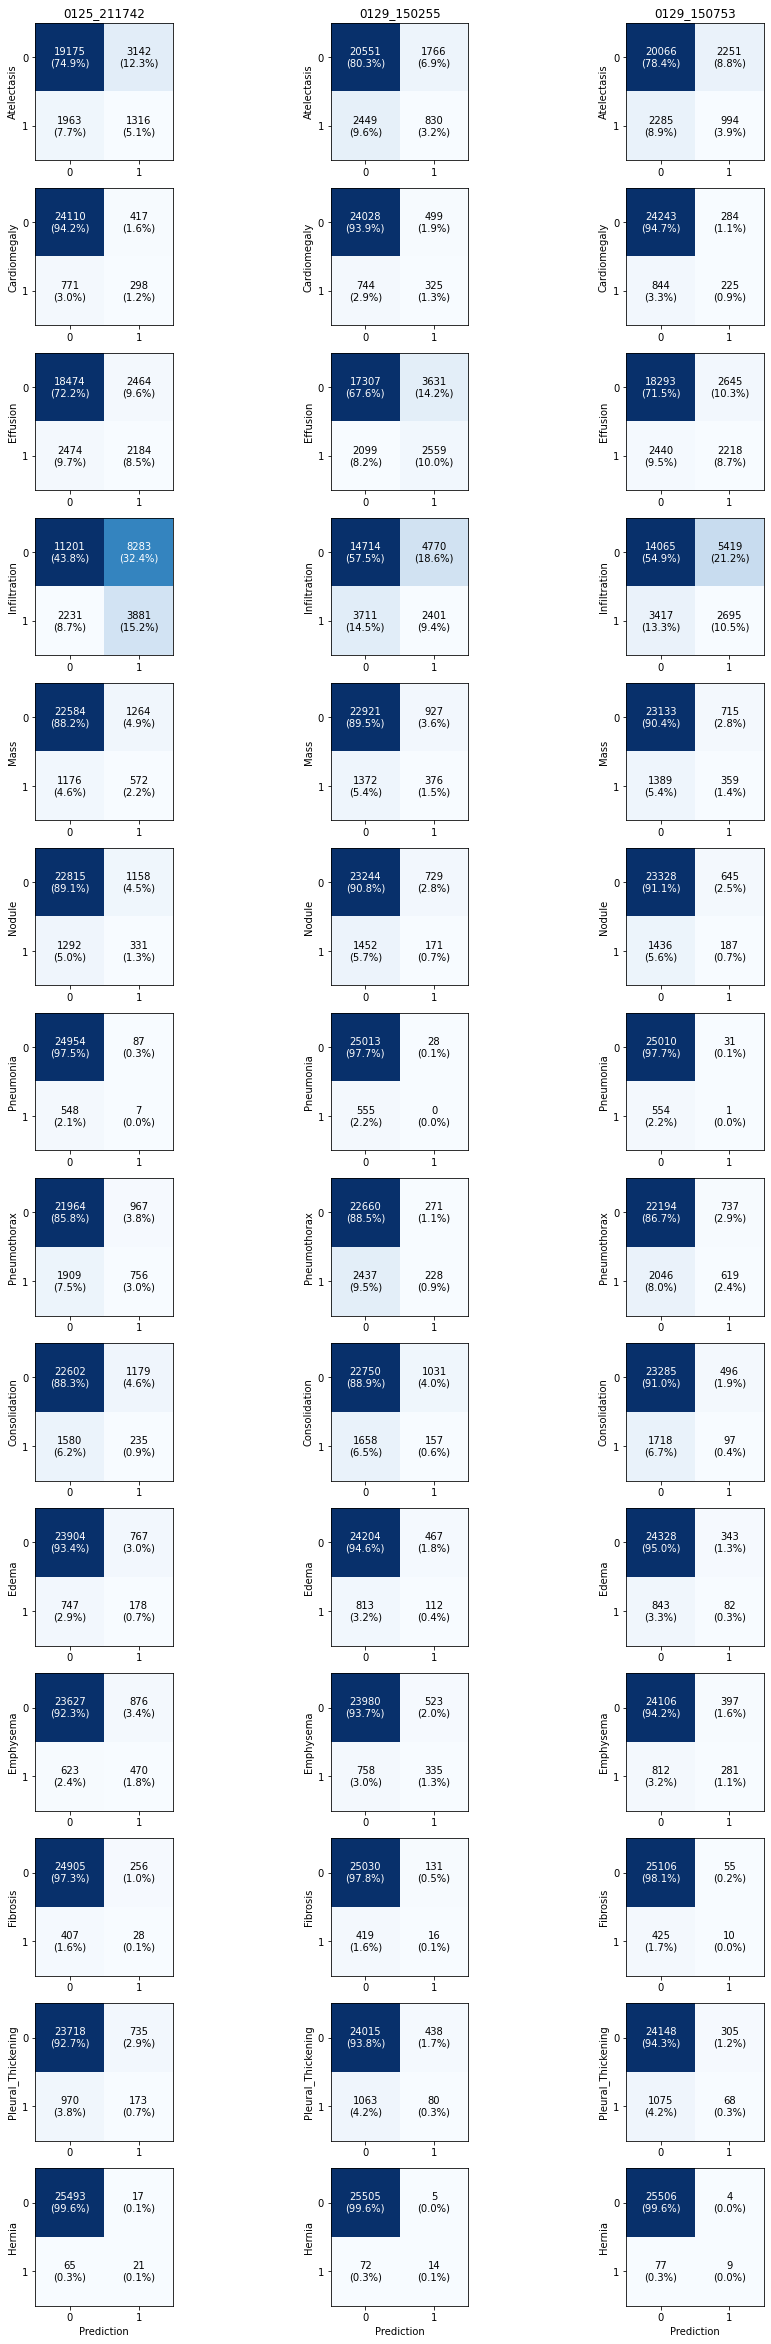

In [81]:
plot_cms_multiple_runs(run_names, 'test', percentage=True)

## Prediction distribution

In [107]:
def plot_distributions(run_names, dataset_types='test', density=True):
    diseases = list(CXR14_DISEASES) # For other datasets, this should be changed
    
    if isinstance(dataset_types, str):
        dataset_types = (dataset_types,)
    
    n_diseases = len(diseases)
    n_runs = len(run_names)
    n_dtypes = len(dataset_types)
    
    n_rows = n_diseases
    n_cols = n_runs * n_dtypes
    
    plt.figure(figsize=((n_runs*n_dtypes)*5, n_diseases*3))
    
    for i_run, run_name in enumerate(run_names):
        df = load_outputs_csv(run_name)
        metrics = load_metrics(run_name)
        
        print(run_name)
        
        for i_dtype, dataset_type in enumerate(dataset_types):
            sub_df = df[df['dataset_type'] == dataset_type]
            sub_metrics = metrics.get(dataset_type, {})
    
            for i_disease, disease in enumerate(diseases):
                gt_col = f'{disease}-gt'
                pred_col = f'{disease}-pred'
                cols = [gt_col, pred_col]

                disease_df = sub_df[cols]

                pos_samples = disease_df[disease_df[gt_col] == 1][pred_col]
                neg_samples = disease_df[disease_df[gt_col] == 0][pred_col]


                # Plot
                subplt_index = (n_runs * n_dtypes) * i_disease + i_run * n_dtypes + i_dtype + 1
                plt.subplot(n_rows, n_cols, subplt_index)

                if i_disease == 0: plt.title(f'{shorten_run_name(run_name)} ({dataset_type})')

                plt.hist(pos_samples, fc=(1, 0, 0, 0.4), label='pos', density=density)
                plt.hist(neg_samples, fc=(0, 0, 1, 0.4), label='neg', density=density)

                if i_disease == n_diseases-1: plt.xlabel('Prediction value')
                
                roc_auc = sub_metrics.get(f'roc_auc_{disease}')
                plt.ylabel(f'{disease} (ROC-AUC={roc_auc:.2f})')

                plt.legend()

In [103]:
run_names = [
    # '0201_180839_cxr14_tfs-small_lr0.0001_normS_size256_sch-roc_auc-p5-f0.1_noes',
    # '0201_180818_cxr14_tfs-small_lr0.0001_balance_normS_size256_sch-roc_auc-p5-f0.1_noes',
    '0201_143527_cxr14_mobilenet-v2_lr0.0001_noig_balance_normS_size256_sch-roc_auc-p5-f0.1_noes',
]

0201_143527_cxr14_mobilenet-v2_lr0.0001_noig_balance_normS_size256_sch-roc_auc-p5-f0.1_noes


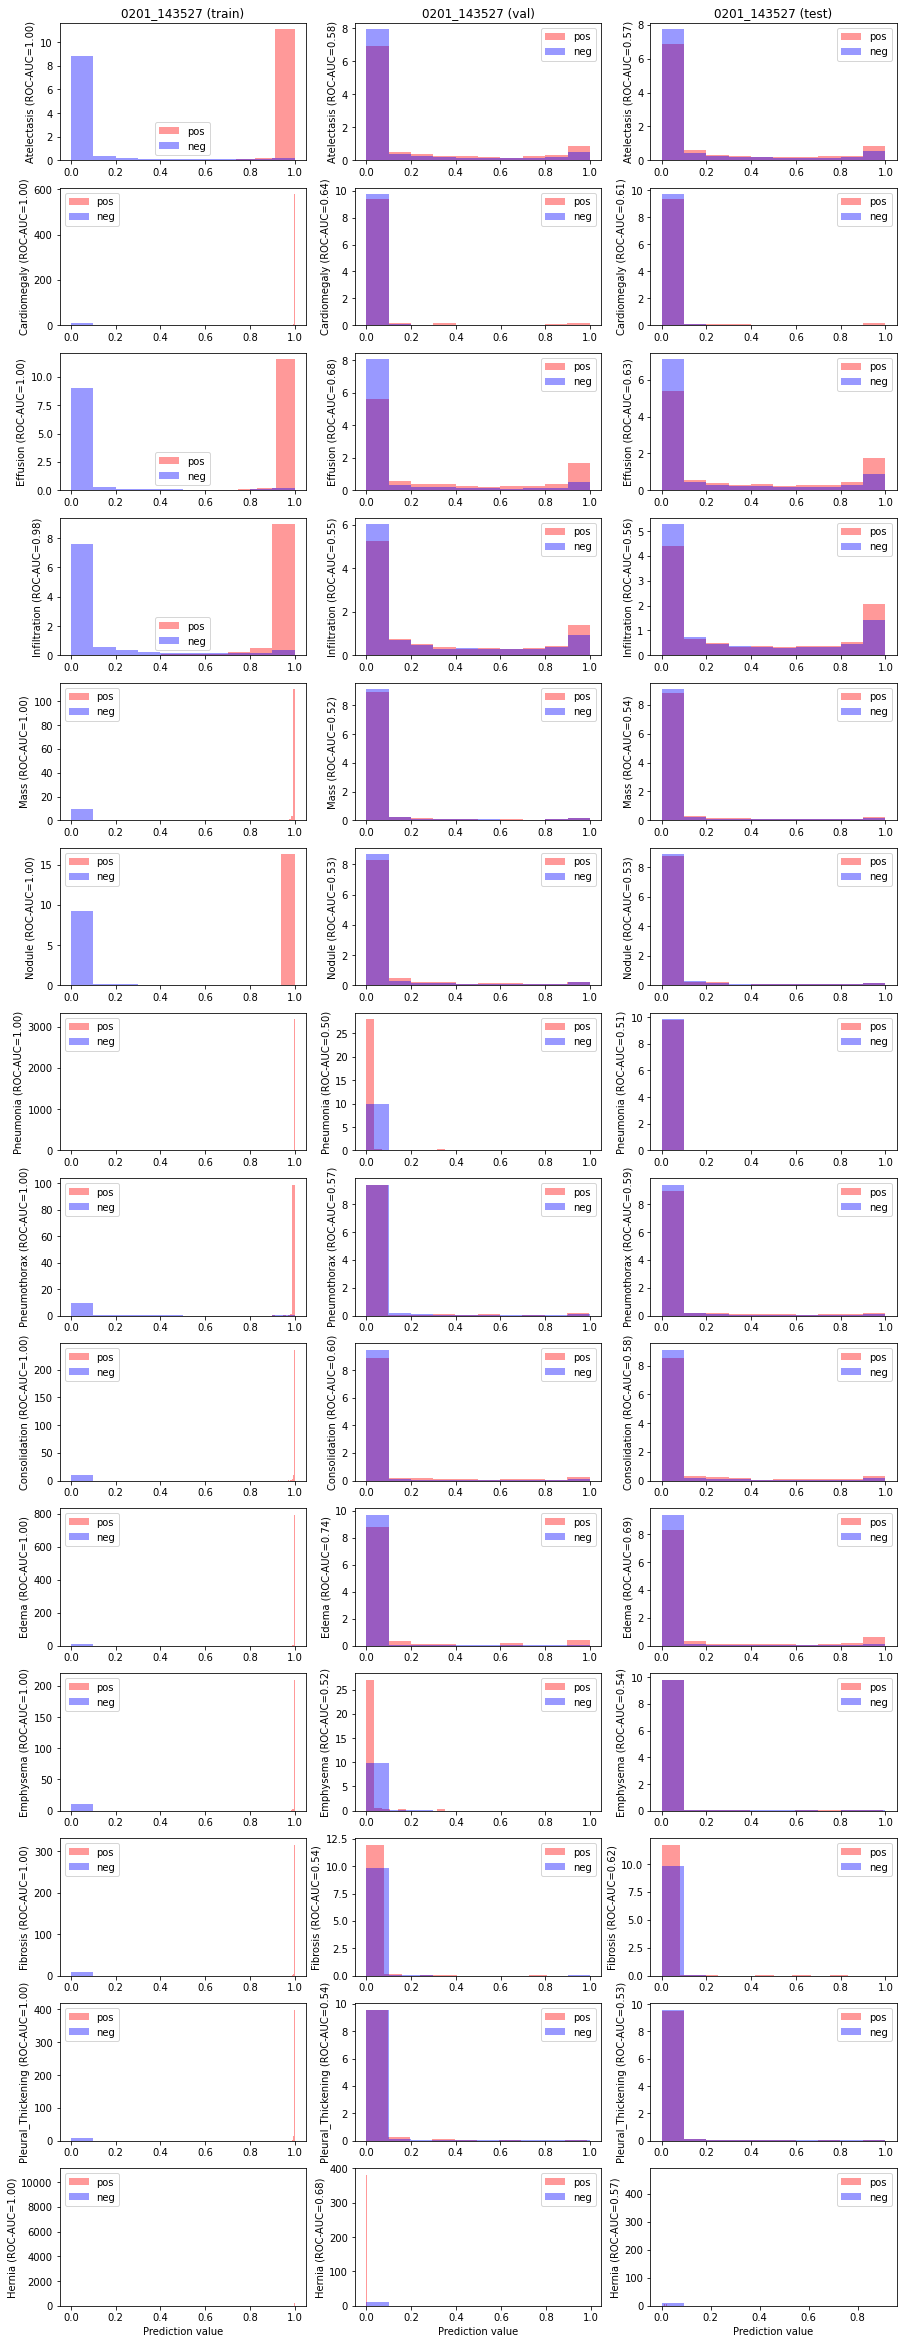

In [108]:
plot_distributions(run_names, ('train', 'val', 'test'))

# Covid examples

In [ ]:
LABELS = ['covid', 'non-c', 'normal']

## Example 1: Covid-UC, size 512, frontal only

In [68]:
results = load_results('0717_120222_covid-x_densenet-121_lr1e-06_os_aug-covid', 'covid-uc_size512_frontal')
list(zip(*results))[0]

('-covid-uc_size512_frontal',)

In [69]:
result = results[0][1]
result

{'all': {'loss': 4.755333423614502,
  'acc': 0.26991869918699185,
  'prec_covid': 0.04608294930875576,
  'prec_Non-COVID': 0.28205128205128205,
  'prec_normal': 0.9507042253521126,
  'recall_covid': 0.8333333333333334,
  'recall_Non-COVID': 0.14864864864864866,
  'recall_normal': 0.2611218568665377,
  'spec_covid': 0.29949238578680204,
  'spec_Non-COVID': 0.9482439926062847,
  'spec_normal': 0.9285714285714286,
  'cm': [[20, 4, 0], [55, 12, 7], [342, 35, 140]]}}

In [70]:
cm = result['all']['cm']

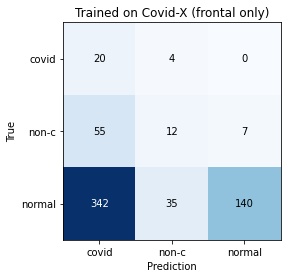

In [73]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plot_cm(cm, labels=LABELS, title='Trained on Covid-X (frontal only)', percentage=False)

## Example 2: Covid-X + Covid-UC

In [65]:
results = load_results('0722_201835_covid-uc_densenet-121_lr0.0001_os-max10_aug_pre-covid-x')
list(zip(*results))[0]

('',)

In [66]:
cm = results[0][1]['val']['cm']

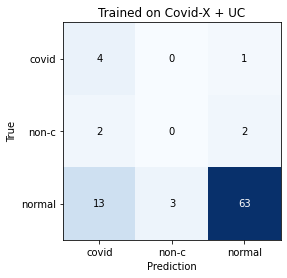

In [67]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plot_cm(cm, labels=LABELS, title='Trained on Covid-X + UC', percentage=False)

## Example 3

In [54]:
results = load_results('0722_193534_covid-uc_densenet-121_lr0.0001_os-max10_aug_size256')
list(zip(*results))[0]

('',)

In [61]:
cm = results[0][1]['val']['cm']

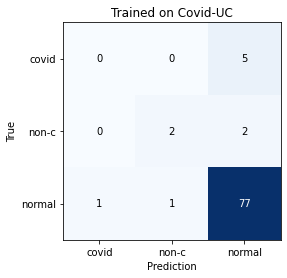

In [64]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plot_cm(cm, labels=LABELS, title='Trained on Covid-UC', percentage=False)

## Example 4: winner

In [74]:
results = load_results('0717_120222_covid-x_densenet-121_lr1e-06_os_aug-covid')
list(zip(*results))[0]

('',
 '-covid-uc_size256_frontal',
 '-covid-uc_size512_frontal',
 '-covid-uc_size512',
 '-covid-uc_size256')

In [79]:
cm = results[0][1]['test']['cm']

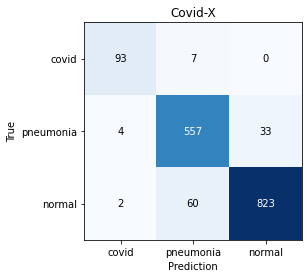

In [83]:
plot_cm(cm, labels=['covid', 'pneumonia', 'normal'], title='Covid-X', percentage=False)